In [1]:
import numpy as np 
import pandas as pd
from helpers import * 
import warnings
from pandas.errors import SettingWithCopyWarning
from sklearn.preprocessing import StandardScaler

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)
ufc = pd.read_csv('ufc-master.csv')

In [2]:
AD = data_prep_and_feat_engineering(ufc, cat_thresh=0.001, squared_thresh=0.0625)
best_approach = ufc.copy() ## creating a new copy of the data to manipulate
best_cols = AD['approach 6'][1] ## features from approach 6
best_approach, best_cols = performance_index(best_approach, best_cols, diff=True) ## creating performance index difference variable
best_approach.head()

,R_fighter,B_fighter,R_odds,B_odds,R_ev,B_ev,date,location,country,Winner,...,total_fight_time_secs,r_dec_odds,b_dec_odds,r_sub_odds,b_sub_odds,r_ko_odds,b_ko_odds,R_perf_idx,B_perf_idx,perf_diff
0,Thiago Santos,Johnny Walker,-150.0,130,66.666667,130.000000,2021-10-02,"Las Vegas, Nevada, USA",USA,Red,...,1500.0,800.0,900.0,2000.0,1600.0,-110.0,175.0,0.608276,1.355765,-0.747489
1,Alex Oliveira,Niko Price,170.0,-200,170.000000,50.000000,2021-10-02,"Las Vegas, Nevada, USA",USA,Blue,...,900.0,450.0,350.0,700.0,1100.0,550.0,120.0,0.804363,0.929946,-0.125583
2,Misha Cirkunov,Krzysztof Jotko,110.0,-130,110.000000,76.923077,2021-10-02,"Las Vegas, Nevada, USA",USA,Blue,...,900.0,550.0,275.0,275.0,1400.0,600.0,185.0,1.823102,0.541941,1.281161
3,Alexander Hernandez,Mike Breeden,-675.0,475,14.814815,475.000000,2021-10-02,"Las Vegas, Nevada, USA",USA,Red,...,80.0,175.0,900.0,500.0,3500.0,110.0,1100.0,0.502096,0.340000,0.162096
4,Joe Solecki,Jared Gordon,-135.0,115,74.074074,115.000000,2021-10-02,"Las Vegas, Nevada, USA",USA,Blue,...,900.0,165.0,200.0,400.0,1200.0,900.0,600.0,1.007373,0.682422,0.324951


In [3]:
best_approach.shape

(4896, 122)

In [4]:
### dropping nulls
best_approach = best_approach.dropna(subset=best_cols)
print(f"Information loss : {ufc.shape[0] - best_approach.shape[0]} entries")
print(f"Remaining information: {best_approach.shape[0]} entries")

Information loss : 954 entries
Remaining information: 3942 entries


In [5]:
### encoding and separating target, creating features 

best_feats = best_approach[best_cols]
targ = [0 if victor == 'Red' else 1 for victor in best_approach['Winner']]

In [8]:
### resampling 

best_feats_rs, best_targ_rs = resample_dataframe(best_feats, targ)

In [10]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
num, cat = num_and_cat(best_feats_rs)

for col in cat:
    best_feats_rs[col] = le.fit_transform(best_feats_rs[col])


In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, roc_auc_score

rf = RandomForestClassifier()

X_train, X_test, y_train, y_test = train_test_split(best_feats_rs, best_targ_rs, test_size=0.2, random_state=0)

rf.fit(X_train, y_train)

y_pred_proba = rf.predict_proba(X_test)

logloss = log_loss(y_test, y_pred_proba)

In [12]:
logloss

0.44848699545316884

In [13]:
auc = roc_auc_score(y_test, y_pred_proba[:, 1])

In [14]:
auc

0.8775967014486106

In [18]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier()

X_train, X_test, y_train, y_test = train_test_split(best_feats_rs, best_targ_rs, test_size=0.2, random_state=0)

gb.fit(X_train, y_train)

y_pred_proba = gb.predict_proba(X_test)

logloss = log_loss(y_test, y_pred_proba)

In [20]:
auc = roc_auc_score(y_test, y_pred_proba[:, 1])

In [21]:
auc

0.7289062798608723

In [22]:
from sklearn.ensemble import BaggingClassifier

bag = BaggingClassifier()

X_train, X_test, y_train, y_test = train_test_split(best_feats_rs, best_targ_rs, test_size=0.2, random_state=0)

bag.fit(X_train, y_train)

y_pred_proba = bag.predict_proba(X_test)

logloss = log_loss(y_test, y_pred_proba)


In [24]:
logloss

0.7500328121615062

In [25]:
ml_dict = {'rf' : rf,
           'gb' : gb, 
           'bag' : bag}



In [26]:
from sklearn.metrics import accuracy_score, precision_score

def performance_report(feats, targ, ml_dict):
    
    X_train, X_test, y_train, y_test = train_test_split(feats, targ, test_size=0.2, random_state=0)
    
    results_dict = {}
    
    for key in ml_dict.keys():
        model = ml_dict[key]
        model.fit(X_train, y_train)
        model_preds = model.predict(X_test)
        model_preds_probs = model.predict_proba(X_test)
        m_acc = accuracy_score(model_preds, y_test)
        m_pre = precision_score(y_test, model_preds)
        m_log = log_loss(y_test, model_preds_probs)
        m_auc = roc_auc_score(y_test, model_preds_probs[:, 1])
        
        print(f"model - {key}")
        print(f"acc - {m_acc:.2f} ...... precision - {m_pre:.2f} ...... ")
        print(f"log loss - {m_log:.2f} ...... AUC -  {m_auc:.2f}")
        print('***********************************************')
        
        results_dict[key] = (m_acc, m_pre, m_log, m_auc)
        
    
    return results_dict
        
    
    

In [27]:
results = performance_report(best_feats_rs, best_targ_rs, ml_dict)

model - rf
acc - 0.78 ...... precision - 0.77 ...... 
log loss - 0.45 ...... AUC -  0.88
***********************************************
model - gb
acc - 0.68 ...... precision - 0.67 ...... 
log loss - 0.61 ...... AUC -  0.73
***********************************************
model - bag
acc - 0.76 ...... precision - 0.75 ...... 
log loss - 0.83 ...... AUC -  0.84
***********************************************


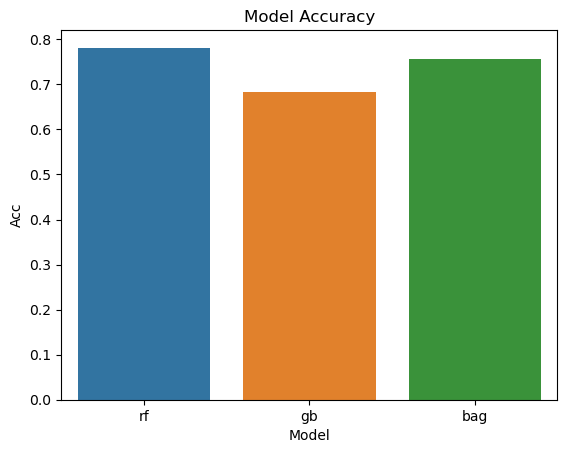

In [30]:
import matplotlib.pyplot as plt 
import seaborn as sns 

mods = list(results.keys())
acc = [val[0] for val in list(results.values())]
pre = [val[1] for val in list(results.values())]
log = [val[2] for val in list(results.values())]
auc = [val[3] for val in list(results.values())]

# Create barplot using seaborn
sns.barplot(x=mods, y=acc)

# Add labels and title
plt.xlabel('Model')
plt.ylabel('Acc')
plt.title('Model Accuracy')

# Show the plot
plt.show()

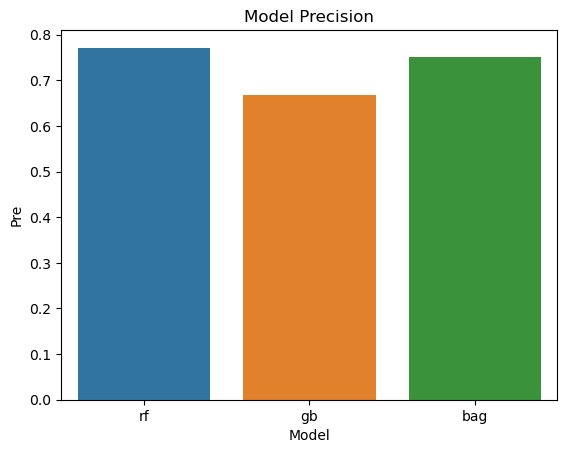

In [31]:
# Create barplot using seaborn
sns.barplot(x=mods, y=pre)

# Add labels and title
plt.xlabel('Model')
plt.ylabel('Pre')
plt.title('Model Precision')

# Show the plot
plt.show()

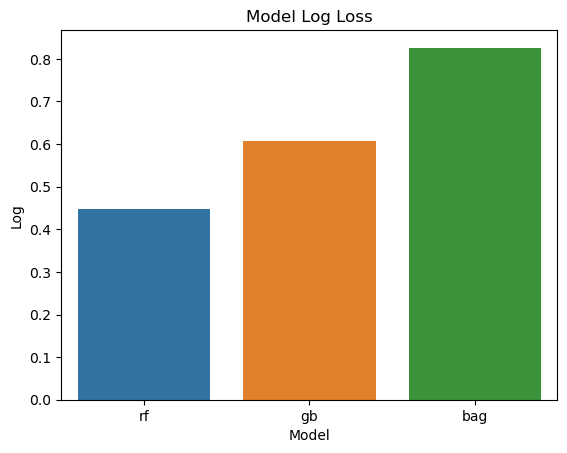

In [32]:
# Create barplot using seaborn
sns.barplot(x=mods, y=log)

# Add labels and title
plt.xlabel('Model')
plt.ylabel('Log')
plt.title('Model Log Loss')

# Show the plot
plt.show()

In [ ]:
# Create barplot using seaborn
sns.barplot(x=mods, y=acc)

# Add labels and title
plt.xlabel('Model')
plt.ylabel('Acc')
plt.title('Model Accuracy')

# Show the plot
plt.show()

In [33]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Define the scoring metrics
scoring = {
    'precision': make_scorer(precision_score),
    'auc': make_scorer(roc_auc_score),
    'log_loss': make_scorer(log_loss, greater_is_better=False, needs_proba=True)
}

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, 
                           scoring=scoring, refit=False, cv=5, verbose=2, n_jobs=-1, 
                           return_train_score=True)

# Fit GridSearchCV to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Get the best scores
best_scores = grid_search.cv_results_
print("Best scores:", best_scores)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [ ]:
grid_search

[{'max_depth': None,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 50},
 {'max_depth': None,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 100},
 {'max_depth': None,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 200},
 {'max_depth': None,
  'min_samples_leaf': 1,
  'min_samples_split': 5,
  'n_estimators': 50},
 {'max_depth': None,
  'min_samples_leaf': 1,
  'min_samples_split': 5,
  'n_estimators': 100},
 {'max_depth': None,
  'min_samples_leaf': 1,
  'min_samples_split': 5,
  'n_estimators': 200},
 {'max_depth': None,
  'min_samples_leaf': 1,
  'min_samples_split': 10,
  'n_estimators': 50},
 {'max_depth': None,
  'min_samples_leaf': 1,
  'min_samples_split': 10,
  'n_estimators': 100},
 {'max_depth': None,
  'min_samples_leaf': 1,
  'min_samples_split': 10,
  'n_estimators': 200},
 {'max_depth': None,
  'min_samples_leaf': 2,
  'min_samples_split': 2,
  'n_estimators': 50},
 {'max_depth': None,
  'min_samples_leaf'

In [ ]:
.